# Grid Search & Model Tuning
### While the generic set of hyperparameters for each algorithm provides a starting point for analysis and will generally result in a well-performing model, it may not have the optimal configurations for your particular dataset and business problem. In order to find the best hyperparameters for your data, you need to tune them

### Import required libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from imblearn.combine import SMOTETomek

### Read Preprocessed data

In [7]:
df = pd.read_csv("data/preprocessed_data.csv", index_col=0)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,NewAGT,CreditsScore,AgeScore,BalanceScore,EstSalaryScore,NewEstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember,Exited
RowNumber,,,,,,,,,,,,,,,,,,,,
1,-0.246269,0.416667,-0.75,-0.761480,0.0,0.011739,0.666667,-0.2,0.50,-0.9,0.1,0.011739,1,0,0,1,0,1,1,1
2,-0.328358,0.333333,-1.00,-0.104906,0.0,0.125512,0.666667,-0.2,0.50,-0.1,0.1,0.125512,0,0,1,1,0,0,1,0
3,-1.119403,0.416667,0.75,0.489346,2.0,0.139630,0.166667,-0.8,0.50,0.9,0.1,0.139630,1,0,0,1,0,1,0,1
4,0.350746,0.166667,-1.00,-0.761480,1.0,-0.064717,0.500000,0.4,0.25,-0.9,-0.1,-0.064717,1,0,0,1,0,0,0,0
5,1.477612,0.500000,-0.75,0.221806,0.0,-0.214561,0.750000,1.0,0.50,0.5,-0.3,-0.214561,0,0,1,1,0,1,1,0


In [8]:
X = df.drop(["Exited"], axis = 1)
y = df["Exited"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=12345)

In [11]:
smk = SMOTETomek()

X_train, y_train = smk.fit_sample(X_train, y_train)
X_test, y_test = smk.fit_sample(X_test, y_test)

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12670, 19) (3116, 19) (12670,) (3116,)


## Grid Search
### Searches for optimum hyperparameters exhaustively through a manually specified subset of the hyperparameter space of the targeted algorithm

In [23]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(500, 1000), 
     'subsample':(0.5, 0.8),
     'max_depth':(5, 10),
     'learning_rate':(0.01, 0.05)     
}

model = GridSearchCV(GradientBoostingClassifier(),parameters,cv=3,iid=False, scoring='accuracy', verbose=1)
model.fit(X_train, np.ravel(y_train))
model.best_score_, model.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 28.7min finished
C:\Users\Shlok\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Wall time: 30min 41s


(0.8922936924464834,
 {'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 1000,
  'subsample': 0.8})

In [27]:
parameters = {
     'n_estimators':(100, 500, 1000), 
     'subsample':(0.4, 0.6, 0.8),
     'max_depth':(2, 5, 10),
     'learning_rate':(0.01, 0.05)
}

model = GridSearchCV(LGBMClassifier(),parameters,cv=3,iid=False, scoring='accuracy', verbose=1)
model.fit(X_train, np.ravel(y_train))
model.best_score_, model.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  2.6min finished
C:\Users\Shlok\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


(0.8806401613939526,
 {'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 1000,
  'subsample': 0.4})

In [30]:
models = []
models.append(('XGB', GradientBoostingClassifier(random_state = 12345,learning_rate = 0.05, max_depth = 5, 
                                                 min_samples_split = 2, n_estimators = 500, subsample = 0.8)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345,  learning_rate = 0.05, max_depth = 3, n_estimators = 1000)))
models.append(("CatBoost", CatBoostClassifier(random_state = 12345, verbose = False, depth = 10, 
                                              iterations = 1000, l2_leaf_reg = 5, learning_rate = 0.01)))

for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

XGB: (0.907134)
LightGBM: (0.910668)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CatBoost: (0.901028)


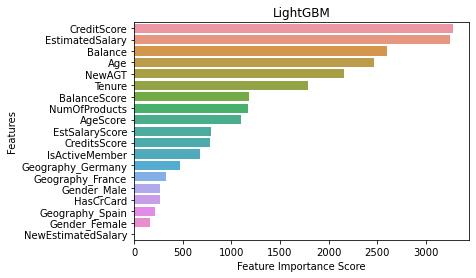

In [36]:
model = LGBMClassifier(random_state = 12345,  learning_rate = 0.05, max_depth = 5, n_estimators = 1000)
base = model.fit(X_train,y_train)
y_pred = base.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
feature_imp = pd.Series(base.feature_importances_,
                index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('LightGBM')
plt.show()